In [2]:
!pip install qiskit


     |████████████████████████████████| 2.9MB 2.8MB/s 
     |████████████████████████████████| 23.1MB 1.2MB/s 
     |████████████████████████████████| 143kB 46.8MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 1.8MB 39.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 5.6MB 32.0MB/s 
     |████████████████████████████████| 153kB 45.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 24.3MB 1.2MB/s 
     |████████████████████████████████| 573kB 44.3MB/s 
     |████████████████████████████████| 2.3MB 35.8MB/s 
  Created wheel for qiskit: filename=qiskit-0.16.0-cp36-none-any.whl size=2896 sha256=ac6c84f5ca38bad62de4620d331d69c34862815d4c23d0bb5b3724c163203c67
  Stored in directory: /root/.cache/pip/wheels/b4/a0/e5/38c49b038739c1ff3c

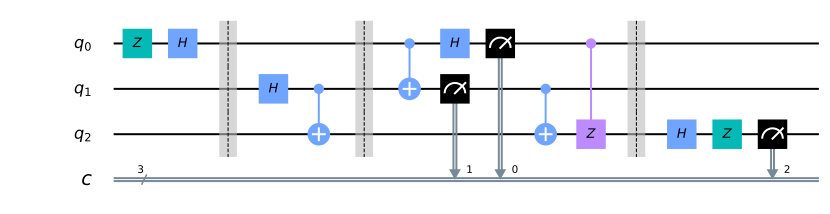

In [12]:
# make the imports that are necessary for our work
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg'
# Makes the images look nice
secret_unitary = 'hz'
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

# Create the quantum circuit with 3 qubits and 3 classical bits
qc = QuantumCircuit(3, 3)

# ''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
# q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
#       which she doesn't know)
# q[1]: Alice's second qubit
# q[2]: Bob's qubit, which will be the destination for the teleportation
# '''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, qc.qubits[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(1)
qc.cx(1, 2)
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(0, 1)
qc.h(0)
qc.measure(0, 0)
qc.measure(1, 1)
qc.cx(1, 2)
qc.cz(0, 2)
qc.barrier()

# '''
# In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
# As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
# since for a unitary u, u^dagger u = I.
# '''
apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)
qc.measure(2, 2)
qc.draw(output='mpl')



{'011': 258, '000': 252, '001': 258, '010': 256}


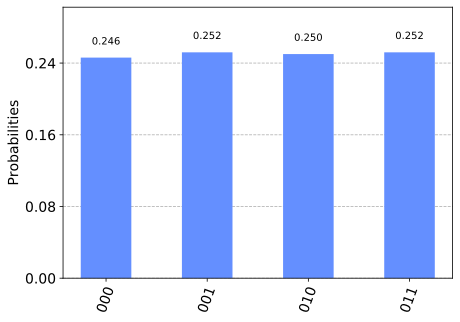

In [13]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)